### Install & Import the required libraries

In [1]:
# %pip install scanpy
# %pip install leidenalg

In [2]:
import scanpy as sc
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score


### Reading the dataset as AnnData objects

In [3]:
adata1 = sc.read(r'dataset_extracted/GSM5201883/matrix.mtx.gz', cache=True).transpose()
adata1.var_names = pd.read_csv(r'dataset_extracted/GSM5201883/features.tsv.gz', header=None, sep='\t')[1]
adata1.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201883/barcodes.tsv.gz', header=None)[0])

In [4]:
adata1

AnnData object with n_obs × n_vars = 5538 × 33538

In [5]:
adata2 = sc.read(r'dataset_extracted/GSM5201884/matrix.mtx.gz', cache=True).transpose()
adata2.var_names = pd.read_csv(r'dataset_extracted/GSM5201884/features.tsv.gz', header=None, sep='\t')[1]
adata2.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201884/barcodes.tsv.gz', header=None)[0])

In [6]:
adata2

AnnData object with n_obs × n_vars = 10756 × 33538

In [7]:
adata3 = sc.read(r'dataset_extracted/GSM5201885/matrix.mtx.gz', cache=True).transpose()
adata3.var_names = pd.read_csv(r'dataset_extracted/GSM5201885/features.tsv.gz', header=None, sep='\t')[1]
adata3.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201885/barcodes.tsv.gz', header=None)[0])

In [8]:
adata3

AnnData object with n_obs × n_vars = 6753 × 33538

In [9]:
adata4 = sc.read(r'dataset_extracted/GSM5201886/matrix.mtx.gz', cache=True).transpose()
adata4.var_names = pd.read_csv(r'dataset_extracted/GSM5201886/features.tsv.gz', header=None, sep='\t')[1]
adata4.obs_names = pd.Series(pd.read_csv(r'dataset_extracted/GSM5201886/barcodes.tsv.gz', header=None)[0])

In [10]:
adata4

AnnData object with n_obs × n_vars = 9676 × 33538

In [11]:

# matrix file has row and column names, so remove them:
adata1.var_names_make_unique()
adata2.var_names_make_unique()
adata3.var_names_make_unique()
adata4.var_names_make_unique()

### Merging the 4 AnnData objects

In [12]:
adata_list = [adata1, adata2, adata3, adata4]
adata_merged = ad.AnnData.concatenate(*adata_list, join='outer')


C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [13]:

adata_merged.obs_names = pd.concat([pd.Series(adata1.obs_names), 
                              pd.Series(adata2.obs_names), 
                              pd.Series(adata3.obs_names), 
                              pd.Series(adata4.obs_names)], join='outer')


In [14]:
adata_merged.var_names = adata1.var_names

In [15]:
adata_merged.obs_names_make_unique()


In [16]:
adata = adata_merged

In [17]:
adata.shape

(32723, 33538)

In [18]:
num_cells = adata.shape[0]
num_genes = adata.shape[1]

print(f'Total number of cells: {num_cells}')
print(f'Total number of genes: {num_genes}')

Total number of cells: 32723
Total number of genes: 33538


# DATA PREPROCESSING 

### Genes that yield the highest fraction of counts in each single cell, across all cells

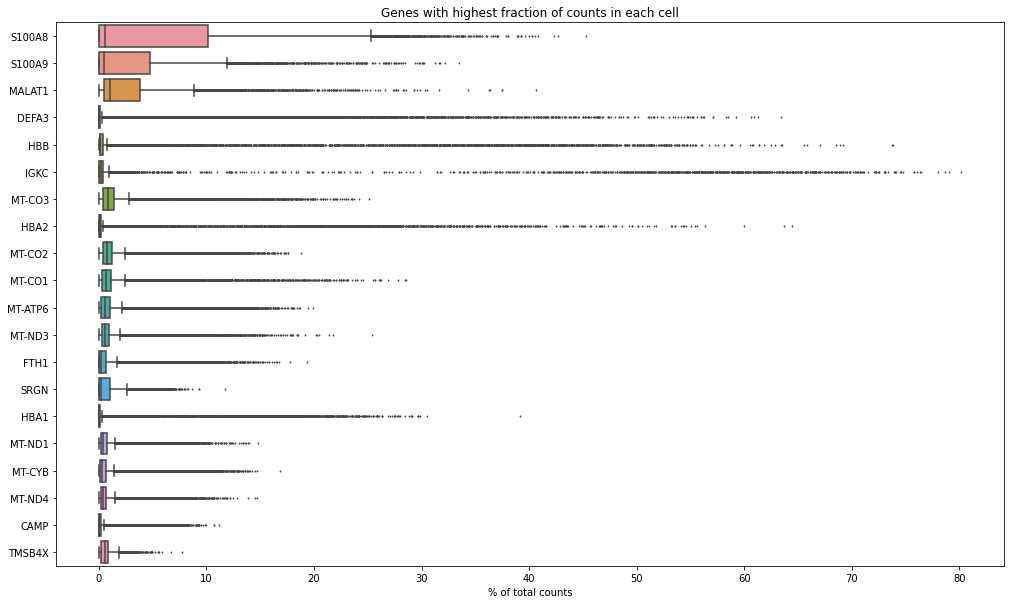

In [19]:
sc.pl.highest_expr_genes(adata, n_top=20, show=False)
fig = plt.gcf()
fig.set_size_inches(17, 10)

plt.title("Genes with highest fraction of counts in each cell")
plt.show()

### Filtering out cells that have less than 200 genes, and genes that are detected in less than 3 cells

In [20]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [21]:
num_cells = adata.shape[0]
num_genes = adata.shape[1]

print(f'Total number of cells: {num_cells}')
print(f'Total number of genes: {num_genes}')

Total number of cells: 31583
Total number of genes: 22589


In [22]:
# Normalization
sc.pp.normalize_total(adata, target_sum=1e4)

In [23]:
# Logarithamize the data
sc.pp.log1p(adata)


### Identify highly-variable genes

In [25]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)


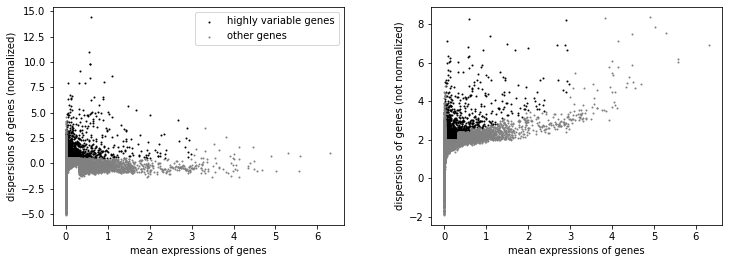

In [26]:
sc.pl.highly_variable_genes(adata)


In [27]:
# Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
adata.raw = adata


In [28]:
# Filtering
adata = adata[:, adata.var.highly_variable]


In [29]:
# Scaling
sc.pp.scale(adata, max_value=10)


C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## PRINCIPLE COMPONENT ANALYSIS

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [30]:
sc.tl.pca(adata, svd_solver='arpack')


### Scatter Plots

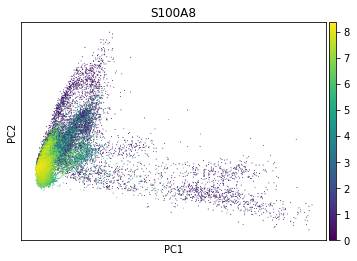

In [31]:
sc.pl.pca(adata, color='S100A8')


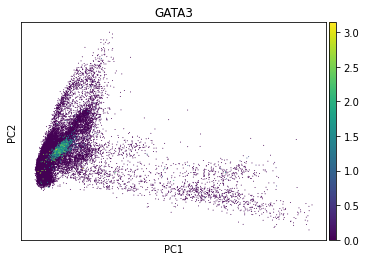

In [32]:
sc.pl.pca(adata, color='GATA3')


### Inspect the contribution of single PCs to the total variance in the data
This gives us information about how many PCAs we should consider in order to compute the neighborhood relations of cells

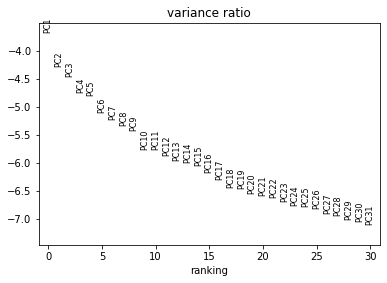

In [33]:
sc.pl.pca_variance_ratio(adata, log=True)


### Computing the Neighbourhood Graph

In [35]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=31)


C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Clustering the neighborhood graph
As with Seurat and many other frameworks, the Leiden graph-clustering method (community detection based on optimizing modularity) by Traag *et al.* (2018) is recommended. Note that Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [37]:
sc.tl.leiden(adata)


### Embedding the neighborhood graph
Embedding the graph in two dimensions using UMAP (McInnes et al., 2018). 
It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.

### Comparing the results with and without PAGA

In [38]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False) 
sc.tl.umap(adata, init_pos='paga')

In [39]:
# Compute silhouette score
silhouette_scores = silhouette_score(
    adata.obsm['X_umap'],
    adata.obs['leiden'].values,
    metric='euclidean'
)

print("Mean silhouette score:", silhouette_scores)

Mean silhouette score: 0.36802676


### Plotting the UMAP

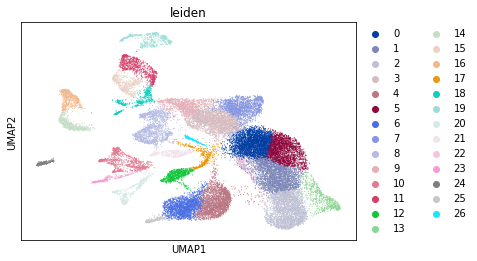

In [40]:
sc.pl.umap(adata, color=['leiden'])


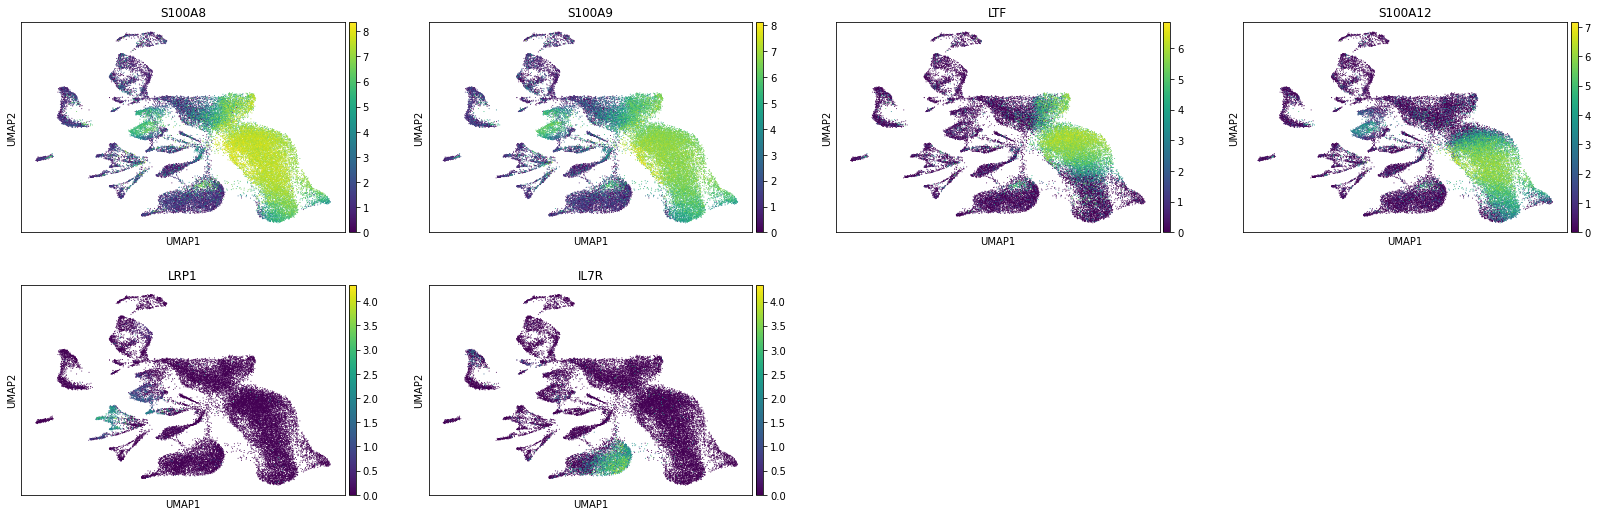

In [41]:
sc.pl.umap(adata, color=['S100A8','S100A9','LTF', 
                        'S100A12', 'LRP1', 'IL7R'])


### Finding marker genes
Let us compute a ranking for the highly differential genes in each cluster.
The simplest and fastest method to do so is the **t-test**.

C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_g

C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\tools\_rank_genes_gr

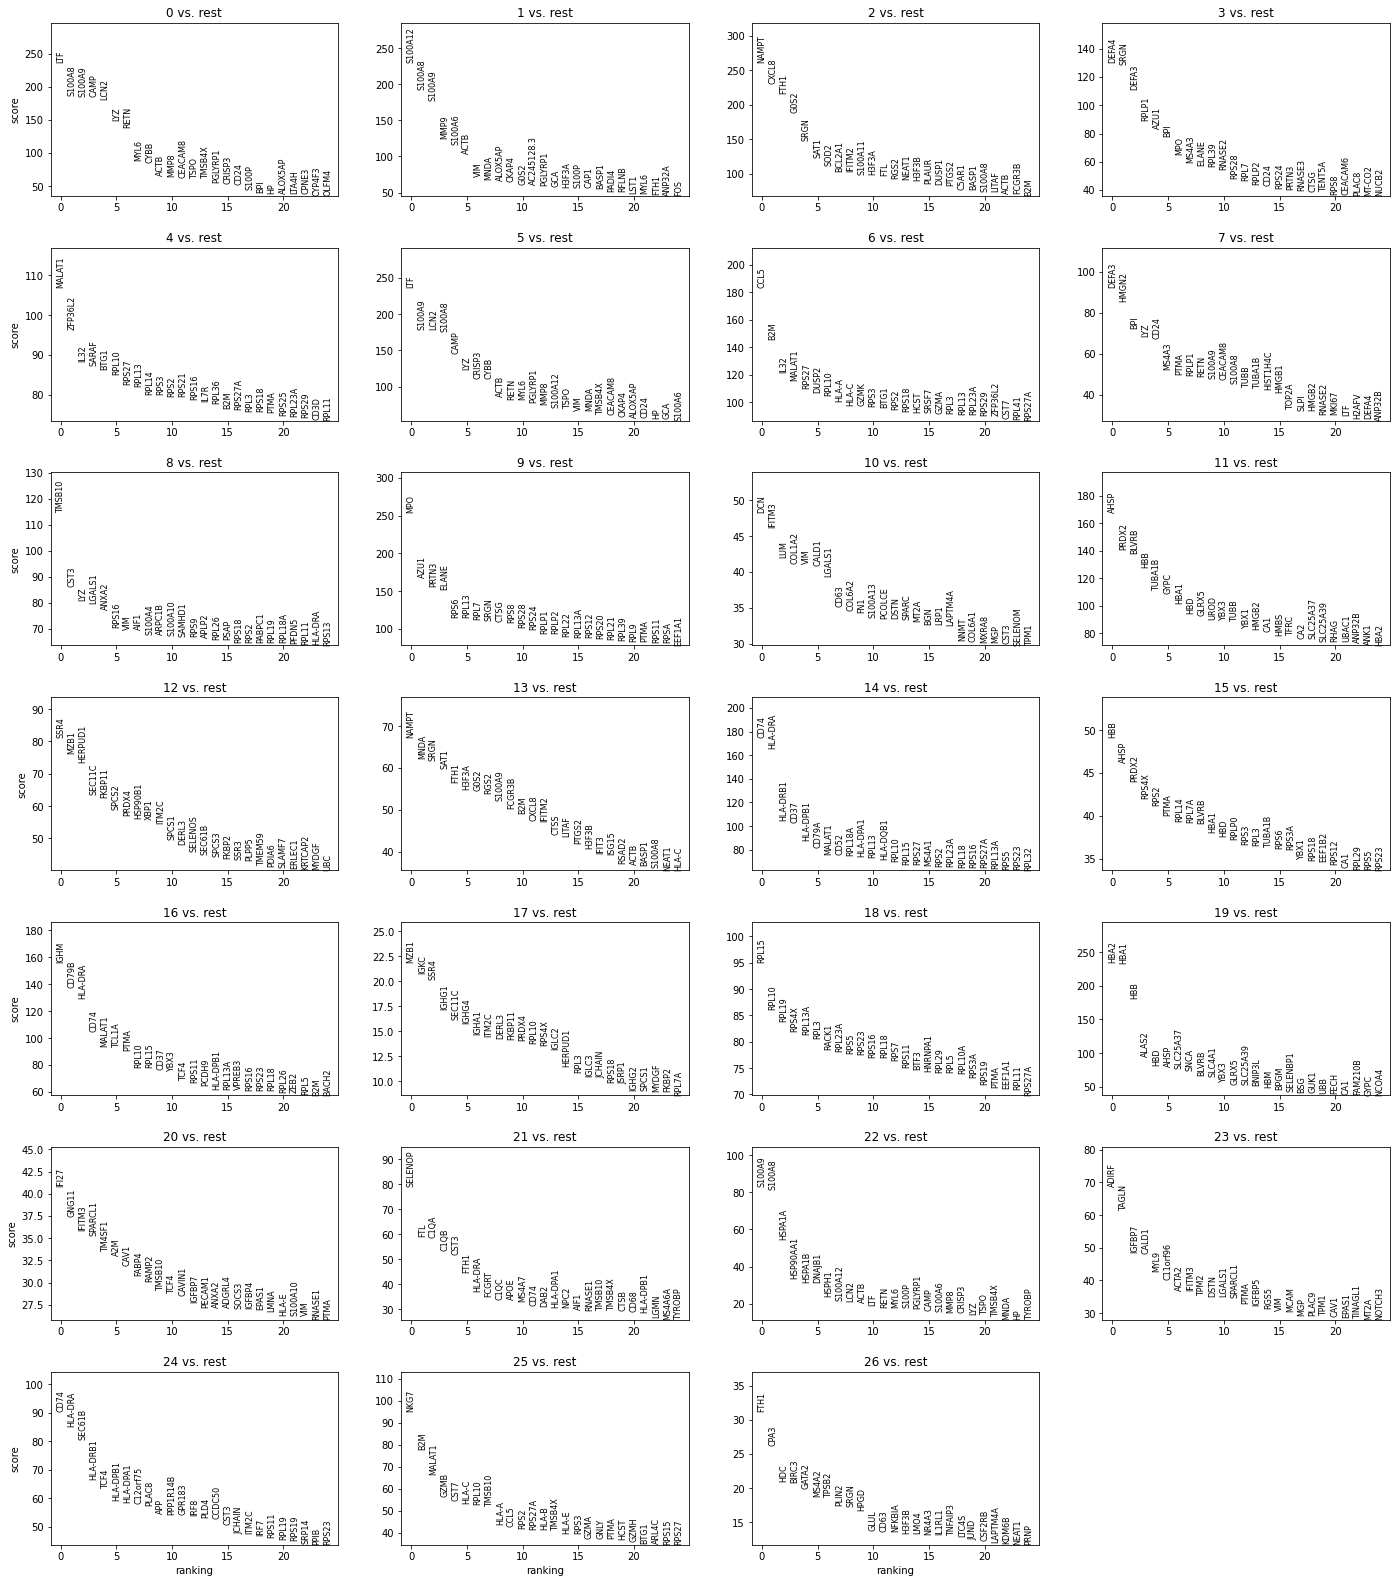

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [45]:
num_clusters = pd.Series(adata.obs['leiden']).nunique()
num_clusters

27

## RESULTS

### Marker genes picked from each cluster (based on references):



| Cluster | Marker Genes                           | Description                    |
| ------- | ---------------------------------------| ------------------------------ |
| 0       | LTF, AHSP, ATP2B1                      | iron homeostasis and transport |
| 1       | S100A8 and S100A9                      | inflammatory response (S100 family) |
| 2       | DEFA3, PRTN3, LYZ, BPI                 | defense against bacterial infections |
| 3       | CAMP, LGALS1, ELANE, CD74              | immune response |
| 4       | FTH1, RPS27, RPL13A, RPS4X             | protein synthesis and ribosome biogenesis |
| 5       | RPL10, RPS16, RPL13, and RPL7A         | ribosomal proteins |
| 6       | VIM and LGALS1                         | cytoskeleton organization and cell motility |
| 7       | HLA-A                                  | major histocompatibility complex (MHC) molecules (immune recognition) |
| 8       | ACTB and TPM2                          | cytoskeletal proteins |
| 9       | APOE and SLC4A1                        | lipid metabolism and transport |


In [53]:
new_cluster_names = [
    'iron homeostasis',
    'inflammatory response',
    'bacterial infections defense',
    'immune response',
    'protein synthesis',
    'ribosomal proteins',
    'cytoskeleton organization',
    'immune recognition',
    'cytoskeletal proteins',
    'lipid transport',
]


new_cluster_names.extend([str(i) for i in range(10,27)])
new_cluster_names

['iron homeostasis',
 'inflammatory response',
 'bacterial infections defense',
 'immune response',
 'protein synthesis',
 'ribosomal proteins',
 'cytoskeleton organization',
 'immune recognition',
 'cytoskeletal proteins',
 'lipid transport',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26']

In [54]:

adata.rename_categories('leiden', new_cluster_names)

C:\Users\rithi\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1160: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  self.obs[key].cat.rename_categories(categories, inplace=True)


### Replotting the UMAP with assigned labels

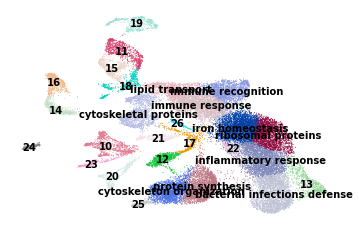

In [55]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)


In [56]:
marker_genes = ['LTF', 'AHSP',
               'S100A8', 'S100A9',
               'DEFA3', 'PRTN3', 'LYZ', 'BPI',
               'CAMP', 'LGALS1', 'ELANE', 'CD74',
                'TPM2',
               'APOE', 'SLC4A1',
               'ATP2B1', 'DGKD',]

### Plotting Dotplot to analyze which genes are highly expressed in which cluster

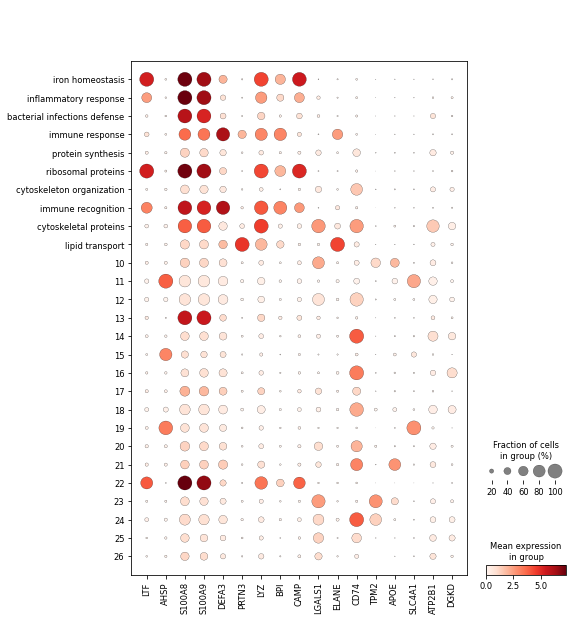

In [57]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');


### Get the names of the top 25 genes for each cluster

In [47]:
top_genes = adata.uns['rank_genes_groups']['names']
high_gs=[]
for i in range(num_clusters):
    cluster_name = 'Cluster ' + str(i)
    genes =list(top_genes[i])[:25]
    high_gs.extend(genes)
    print(f"{cluster_name}: {', '.join(genes)}","\n")


Cluster 0: LTF, S100A12, NAMPT, DEFA4, MALAT1, LTF, CCL5, DEFA3, TMSB10, MPO, DCN, AHSP, SSR4, NAMPT, CD74, HBB, IGHM, MZB1, RPL15, HBA2, IFI27, SELENOP, S100A9, ADIRF, CD74 

Cluster 1: S100A8, S100A8, CXCL8, SRGN, ZFP36L2, S100A9, B2M, HMGN2, CST3, AZU1, IFITM3, PRDX2, MZB1, MNDA, HLA-DRA, AHSP, CD79B, IGKC, RPL10, HBA1, GNG11, FTL, S100A8, TAGLN, HLA-DRA 

Cluster 2: S100A9, S100A9, FTH1, DEFA3, IL32, LCN2, IL32, BPI, LYZ, PRTN3, LUM, BLVRB, HERPUD1, SRGN, HLA-DRB1, PRDX2, HLA-DRA, SSR4, RPL19, HBB, IFITM3, C1QA, HSPA1A, IGFBP7, SEC61B 

Cluster 3: CAMP, MMP9, G0S2, RPLP1, SARAF, S100A8, MALAT1, LYZ, LGALS1, ELANE, COL1A2, HBB, SEC11C, SAT1, CD37, RPS4X, CD74, IGHG1, RPS4X, ALAS2, SPARCL1, C1QB, HSP90AA1, CALD1, HLA-DRB1 

Cluster 4: LCN2, S100A6, SRGN, AZU1, BTG1, CAMP, RPS27, CD24, ANXA2, RPS6, VIM, TUBA1B, FKBP11, FTH1, HLA-DPB1, RPS2, MALAT1, SEC11C, RPL13A, HBD, TM4SF1, CST3, HSPA1B, MYL9, TCF4 

Cluster 5: LYZ, ACTB, SAT1, BPI, RPL10, LYZ, DUSP2, MS4A3, RPS16, RPL13, CALD1, GY